## High-level overview
One of my passions in life is weight lifting for strength and fitness.
I believe that a lot of people have a difficult time getting into consistent weight lifting because they don't know what their end goals may look like.
It's one thing to say "I want to get stronger," but it's more impactful and sets more accountability to say "I have a realistic long term goal of doing a 200 kg bench press."
To solve this problem of people lacking clear goals and/or motivational targets for their personal health in weightlifting I decided to use the powerlifting-database from Kaggle to do the following:

1. Perform high level data cleaning + analysis for lift weight capability vs. other information about the people included in the dataset.
2. Build machine learning models to predict what a maximum lift weight could be for a user based on their characteristics. The model will be trained on a subset of the data and then tested for accuracy on a test set of the data by using the negative mean squared error metric. This will determine the average delta in accuracy prediction for each value and allow for an easy way to identify how well our model is doing for this continuous variable prediction problem. 
3. Build a plotly web app that can be easily hosted on a local machine to act as a GUI for the saved machine learning models. A user of the web app can enter in their characteristics and receive a predicted maximum lift weight that they could set as a future achievable goal.

## Description of Input Data
The input data is captured in openpowerlifting.csv and it includes a powerlifting dataset (obtained from Kaggle under free use - https://www.kaggle.com/datasets/dansbecker/powerlifting-database).
This dataset contains nearly 400,000 results from powerlifting competitions, where the users provide information about themselves (Sex, Equipment, Age, and bodyweight) and their best lift results (squat, bench, and deadlift) in kg are displayed.
This dataset is capturing some of the best powerlifters in the competition circuits, and it is exactly what we can use to model estimated capability for potential powerlifters based on their characteristics.

## Strategy for solving the problem
The strategy to solve my problem (which is people lacking clear goals and/or motivational targets for their personal health in weighlifting) is to take the powerlifting dataset, clean and analyze it, and then train machine learning models that will allow me to predict a user's max lift capabilities based off of providing their personal characteristics.
One model will be created for each of the three lifts, and the strategy will be to test two different ML pipelines test errors against each other to determine which one should be selected.
The 3 models from the selected pipeline will then be saved as .pkl files and hosted in a streamlit web app that will allow any users to input their characteristics to receive a prediction of their maximum lift capabilities.

## Discussion of the expected solution
I expect that the solution will involve a ML pipeline containing a more advanced form of a linear regression model that can be tested with less error vs. a simpler form of linear regression model. I think the generated models will be able to provide relatively accurate predictions on the test data, which in turn will be used in the web app to provide users with estimated lift capabilities that are accurate enough to be used confidently as predicted estimated lifts.

## Metrics with justification
The metric that will be used for evaluating the ML models for lift weights will be negative mean squared error.
This is because our ML model is trying to estimate a continuous value (lift weights that are float values from 0 kg all the way to 500 kg+).
This requires that we get an understanding of how far all of our estimator float results are from the test values, rather than say, a classifier problem that just determines if we were successful or not (1 or 0)
So MSE (mean squared error) was chosen as it accounts for both the variance and bias of the estimation errors on the dataset.
Negative mean squared error was used as it is accepted by the GridSeachCV part of the ML Pipeline for results analysis.


## Exploratory Data Analysis (EDA)

## Data Understanding
Bringing in the key data provided for the analysis.  
Data Set:
df_lift (the openpowerlifting.csv of competitor weightlifting data)

Checking the shapes of our dataset to get an understanding of the number of rows of data and the number of columns to look through for potential analysis.  
Also looking at column headers to understand what data may be present.

In [2]:
import pandas as pd
import numpy as np
from scipy import stats

import sklearn as sk
from sklearn import preprocessing
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error


import matplotlib.pyplot as plt
import seaborn as sns

import pickle

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [3]:
df_lift = pd.read_csv('./openpowerlifting.csv')
print(df_lift.shape)
print(df_lift.columns.tolist())
print(df_lift['Name'].nunique(), 'unique people out of', df_lift.shape[0],'total data points')
df_lift.head()

(386414, 17)
['MeetID', 'Name', 'Sex', 'Equipment', 'Age', 'Division', 'BodyweightKg', 'WeightClassKg', 'Squat4Kg', 'BestSquatKg', 'Bench4Kg', 'BestBenchKg', 'Deadlift4Kg', 'BestDeadliftKg', 'TotalKg', 'Place', 'Wilks']
136687 unique people out of 386414 total data points


MeetID              Name Sex   Equipment   Age     Division  BodyweightKg  \
0       0  Angie Belk Terry   F       Wraps  47.0    Mst 45-49         59.60   
1       0       Dawn Bogart   F  Single-ply  42.0    Mst 40-44         58.51   
2       0       Dawn Bogart   F  Single-ply  42.0  Open Senior         58.51   
3       0       Dawn Bogart   F         Raw  42.0  Open Senior         58.51   
4       0      Destiny Dula   F         Raw  18.0   Teen 18-19         63.68   

  WeightClassKg  Squat4Kg  BestSquatKg  Bench4Kg  BestBenchKg  Deadlift4Kg  \
0            60       NaN        47.63       NaN        20.41          NaN   
1            60       NaN       142.88       NaN        95.25          NaN   
2            60       NaN       142.88       NaN        95.25          NaN   
3            60       NaN          NaN       NaN        95.25          NaN   
4          67.5       NaN          NaN       NaN        31.75          NaN   

   BestDeadliftKg  TotalKg Place   Wilks  
0           70.31   138.35     1  155.05  
1          163.29   401.42     1  456.38  
2          163.29   401.42     1  456.38  
3             NaN    95.25     1  108.29  
4           90.72   122.47     1  130.47

In [4]:
# Checking for nulls, we note that age has ~240k nulls out of ~386k rows of data. We will need age for our predictor, so this leaves around ~146k max data values depending on what else is null.
print(df_lift.isnull().sum())

# Checking for any strange or anomalous values - We found some negative values for lift weights! That doesn't make any sense, so we'll have to remove them in the data cleaning section!
print(df_lift.max())
print(df_lift.min())

MeetID                 0
Name                   0
Sex                    0
Equipment              0
Age               239267
Division           15843
BodyweightKg        2402
WeightClassKg       3812
Squat4Kg          385171
BestSquatKg        88343
Bench4Kg          384452
BestBenchKg        30050
Deadlift4Kg       383614
BestDeadliftKg     68567
TotalKg            23177
Place               1092
Wilks              24220
dtype: int64


C:\Users\AMELATTI\AppData\Local\Temp\ipykernel_20388\186578324.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  print(df_lift.max())


MeetID                    8481
Name              Željko Sebić
Sex                          M
Equipment                Wraps
Age                       95.0
BodyweightKg             242.4
Squat4Kg                 450.0
BestSquatKg             573.79
Bench4Kg                378.75
BestBenchKg              488.5
Deadlift4Kg              418.0
BestDeadliftKg           460.4
TotalKg                1365.31
Wilks                   779.38
dtype: object
MeetID                    0
Name                A Blank
Sex                       F
Equipment         Multi-ply
Age                     5.0
BodyweightKg          15.88
Squat4Kg             -440.5
BestSquatKg          -477.5
Bench4Kg             -360.0
BestBenchKg          -522.5
Deadlift4Kg          -461.0
BestDeadliftKg       -410.0
TotalKg                11.0
Wilks                 13.73
dtype: object


C:\Users\AMELATTI\AppData\Local\Temp\ipykernel_20388\186578324.py:6: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  print(df_lift.min())


## Data Preprocessing (Preparation of Data for Analysis/Modelling)

In [6]:
print(df_lift.shape)

# Drop columns that we aren't going to be using for this analysis (including those with too many nulls)
df_lift = df_lift[['Name','Sex','Equipment','Age','BodyweightKg','BestSquatKg','BestBenchKg','BestDeadliftKg']]

# Drop duplicate rows of data
df_lift = df_lift.drop_duplicates()
print('After drop duplicates:',df_lift.shape),

# Drop rows that have missing data in them (will not be used for training/testing the model)
df_lift = df_lift.dropna(how='any')
print('After drop missing:',df_lift.shape)

# Drop rows that have negative values in them (not possible to have negative weights, entered incorrectly)
df_lift = df_lift[(df_lift['BestSquatKg'] >= 0) & (df_lift['BestBenchKg'] >= 0) & (df_lift['BestDeadliftKg'] >= 0)]
print('After drop negative values for weights:',df_lift.shape)

# Adding in my own potential predictor to the data: "Commitment"
# To create the Commitment column I first take the value_counts of all Names in df_lift
# I then find the max count of Names (37 for one person) and divide the value counts by that number
# Taking the ceiling and then multiplying by 10 results in an official value between 1-10 for commitment
# The goal is to see if somebody who is more "committed" ( attends more events = more name entries) will have heavier max lifts.
# The web app will then allow somebody to estimate their own commitment level to lifting to influence how much their max lifts may be.
commitment_levels =  np.ceil(df_lift['Name'].value_counts() / max(df_lift['Name'].value_counts()) * 10)
df_lift['Commitment'] = df_lift['Name'].map(commitment_levels)

df_lift.head()

(97584, 9)
After drop duplicates: (97584, 8)
After drop missing: (97584, 8)
After drop negative values for weights: (97584, 8)


Name Sex   Equipment   Age  BodyweightKg  BestSquatKg  \
0        Angie Belk Terry   F       Wraps  47.0         59.60        47.63   
1             Dawn Bogart   F  Single-ply  42.0         58.51       142.88   
5         Courtney Norris   F       Wraps  28.0         62.41       170.10   
6           Maureen Clary   F         Raw  60.0         67.31       124.74   
8  Priscilla Sweat Pardue   F       Wraps  52.0         65.95       120.20   

   BestBenchKg  BestDeadliftKg  Commitment  
0        20.41           70.31         1.0  
1        95.25          163.29         2.0  
5        77.11          145.15         2.0  
6        95.25          163.29         1.0  
8        54.43          108.86         1.0

In [7]:
df_lift.describe(include='all')

# Looking into the data a bit, it is clear that the bodybuilding data set contains younger people (with 75% of the data set at age 35 or younger!)
# Additionally, my added "Commitment" column consists of mostly 1s or 2s for values.
# It's also interesting to note that, on average, the BestBenchKg values are less than deadlift or squat. 
# This makes sense to those in the weightlifting field though, as bench press only allows use of your arms and upper body while
# bench press and deadlift make use of larger muscles in the lower body such as glutes, quads along with some upper body muscles.

Name    Sex Equipment           Age  BodyweightKg  \
count            97584  97584     97584  97584.000000  97584.000000   
unique           53752      2         4           NaN           NaN   
top     Jose Hernandez      M       Raw           NaN           NaN   
freq                37  66110     63596           NaN           NaN   
mean               NaN    NaN       NaN     29.674475     85.306578   
std                NaN    NaN       NaN     11.591340     22.921760   
min                NaN    NaN       NaN      7.000000     24.100000   
25%                NaN    NaN       NaN     21.500000     67.600000   
50%                NaN    NaN       NaN     26.500000     82.000000   
75%                NaN    NaN       NaN     35.000000     98.880000   
max                NaN    NaN       NaN     93.000000    242.400000   

         BestSquatKg   BestBenchKg  BestDeadliftKg    Commitment  
count   97584.000000  97584.000000    97584.000000  97584.000000  
unique           NaN           NaN             NaN           NaN  
top              NaN           NaN             NaN           NaN  
freq             NaN           NaN             NaN           NaN  
mean      179.376888    117.144162      201.278381      1.414525  
std        69.590646     51.364422       62.371044      0.825618  
min        13.600000      6.800000       12.000000      1.000000  
25%       125.000000     72.500000      150.000000      1.000000  
50%       175.000000    115.000000      205.000000      1.000000  
75%       225.000000    150.000000      247.500000      2.000000  
max       548.850000    442.250000      440.000000     10.000000

In [8]:
# Confirm we have no missing values for the data we'll be using in our model!
df_lift.isnull().sum()

Name              0
Sex               0
Equipment         0
Age               0
BodyweightKg      0
BestSquatKg       0
BestBenchKg       0
BestDeadliftKg    0
Commitment        0
dtype: int64

c:\Users\AMELATTI\AppData\Local\Ford-Conda\envs\py38_jupyter\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\AMELATTI\AppData\Local\Ford-Conda\envs\py38_jupyter\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


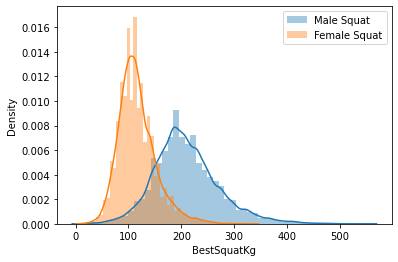

c:\Users\AMELATTI\AppData\Local\Ford-Conda\envs\py38_jupyter\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\AMELATTI\AppData\Local\Ford-Conda\envs\py38_jupyter\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


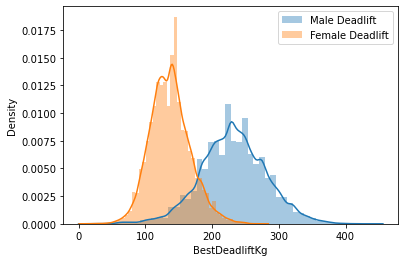

c:\Users\AMELATTI\AppData\Local\Ford-Conda\envs\py38_jupyter\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\AMELATTI\AppData\Local\Ford-Conda\envs\py38_jupyter\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


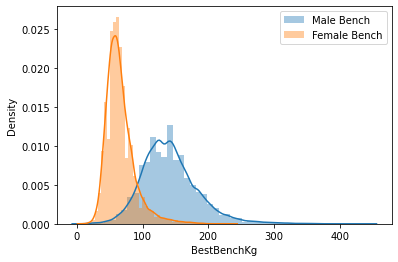

In [9]:
# Comparing lift distributions for Male vs. Female
sns.distplot(df_lift[df_lift['Sex'] == 'M']['BestSquatKg'], label='Male Squat')
sns.distplot(df_lift[df_lift['Sex'] == 'F']['BestSquatKg'], label='Female Squat')

plt.legend()
plt.show()

sns.distplot(df_lift[df_lift['Sex'] == 'M']['BestDeadliftKg'], label='Male Deadlift')
sns.distplot(df_lift[df_lift['Sex'] == 'F']['BestDeadliftKg'], label='Female Deadlift')

plt.legend()
plt.show()

sns.distplot(df_lift[df_lift['Sex'] == 'M']['BestBenchKg'], label='Male Bench')
sns.distplot(df_lift[df_lift['Sex'] == 'F']['BestBenchKg'], label='Female Bench')

plt.legend()
plt.show()


In [10]:
# Comparing Commitment Level vs. BestSquatkg.
# My initial assumption was that somebody who is more committed would, on average, lift heavier weights.
# This can be confounded by a couple things, including # of data points in each commitment bin as well as what type of lifter may be committed.
# 1) There are less data points as we move to the higher commitment levels, potentially skewing out averages with just a couple outliers
# 2) A committed lifter may not be the best lifter. Somebody who is making very small improvements over time may come back multiple times,
# while someone who is strong and improves quickly may only come back once or twice
fig_box2 = px.box(df_lift, x="Commitment", y="BestSquatKg", title="Box plot of Best Squat kg vs. Commitment Level")
fig_box2.show()

In [ ]:
# Quick 3d scatter plot to help visualize the trend for bodyweight and age vs. best squat kg.
# As expected, there's a correlation where younger bodybuilders with higher body weight will have the heaviest squats.

fig = px.scatter_3d(df_lift[df_lift['Sex'] == 'M'], x='Age', y='BodyweightKg', z='BestSquatKg',
                    color='BestSquatKg',
                    title="3D Scatterplot of Best Squat vs. Age and Body Weight for Male Participants")
# , symbol='species')
fig.show()

## Modeling (Model Evaluation and Validation)
In this section we start by looking at our cleaned dataframe, introducing dummies for the equipment type, and then creating the ML pipeline functions.
Hyperparameters are tuned in the functions, and then the results are assessed along with a comparison table.

In [11]:
df_lift.head()

Name Sex   Equipment   Age  BodyweightKg  BestSquatKg  \
0        Angie Belk Terry   F       Wraps  47.0         59.60        47.63   
1             Dawn Bogart   F  Single-ply  42.0         58.51       142.88   
5         Courtney Norris   F       Wraps  28.0         62.41       170.10   
6           Maureen Clary   F         Raw  60.0         67.31       124.74   
8  Priscilla Sweat Pardue   F       Wraps  52.0         65.95       120.20   

   BestBenchKg  BestDeadliftKg  Commitment  
0        20.41           70.31         1.0  
1        95.25          163.29         2.0  
5        77.11          145.15         2.0  
6        95.25          163.29         1.0  
8        54.43          108.86         1.0

In [12]:
# Introduce dummy variables for our categorical columns Sex and Equipment
# Drop first when using pd.get_dummies to ensure we don't have multicollinearity

df_lift_dummies = pd.get_dummies(df_lift.iloc[:,1:3], drop_first=True)

model_data= pd.concat([df_lift, df_lift_dummies], axis=1)

# Drop original categorical sex and equipment columns, also drop Name column because that will not be used in our model
model_data = model_data.drop(columns=['Name','Sex','Equipment'])
model_data.head()

Age  BodyweightKg  BestSquatKg  BestBenchKg  BestDeadliftKg  Commitment  \
0  47.0         59.60        47.63        20.41           70.31         1.0   
1  42.0         58.51       142.88        95.25          163.29         2.0   
5  28.0         62.41       170.10        77.11          145.15         2.0   
6  60.0         67.31       124.74        95.25          163.29         1.0   
8  52.0         65.95       120.20        54.43          108.86         1.0   

   Sex_M  Equipment_Raw  Equipment_Single-ply  Equipment_Wraps  
0      0              0                     0                1  
1      0              0                     1                0  
5      0              0                     0                1  
6      0              1                     0                0  
8      0              0                     0                1

## Functions for the Model Fitting and Evaluating Pipeline!

In [13]:
def train_test_data_prepare(model_data, y_column):
    '''
    train_test_data_prepare works to extract the necessary X and Y data that will be used in train_test_split based on the column we're trying to predict.
    Our data set has three potential lifts to predict (squat, deadlift, bench), and we want an individual model for each. So this function can be applied 3 times to save some typing.

    Inputs:
    model_data - df of the data that we want to use for our modelling purposes
    y_column - the column that will be the value we're trying to predict (Ex: 'BestSquatKg')

    Outputs: 
    Training data to fit the model to in the form of X_train and y_train
    Testing data to test the model on in the form of X_test and y_test
    '''
    X = model_data.drop(columns=['BestSquatKg','BestBenchKg','BestDeadliftKg'])
    Y = model_data[y_column]


    X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.2, random_state=42)

    return X_train, X_test, y_train, y_test


In [14]:
def build_model():

    '''
    build_model will make the MLP consisting of a standard scaler and an ElasticNet classifier.
    We then create a gridsearch object to attempt to determine the optimum parameters for the pipeline.
    Output: model to be used to fit and evaluate data on.

    '''
    # building initial pipeline with standard scaler, and our classifier Support Vector Classifier!
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', ElasticNet())
        
    ])

  # Adding some parameters for our GridSearchCV optimizer to tweak
    # parameters = {'classifier__fit_intercept':[True, False], 'classifier__normalize':[True, False], 'classifier__n_jobs':[1, 3, 5],}
    parameters = {'classifier__alpha':[.0001, .001, .01, .1, 1, 10]}
    # create grid search object
    cv = GridSearchCV(pipeline, param_grid=parameters, cv=5, verbose=1, scoring='neg_mean_squared_error')
    
    return cv

In [15]:
def build_model_2():

    '''
    build_model_2 will make the MLP consisting of a MinMax scaler and a PLS (Partial Least Squares) regression classifier.
    We then create a gridsearch object to attempt to determine the optimum parameters for the pipeline.
    Output: model to be used to fit and evaluate data on.
    

    '''
    # building initial pipeline with standard scaler, and our classifier Support Vector Classifier!
    pipeline = Pipeline([
        ('scaler', MinMaxScaler()),
        ('classifier', PLSRegression())
        
    ])

  # Adding some parameters for our GridSearchCV optimizer to tweak
    parameters = {'classifier__n_components':np.arange(1,8,1)}
    # create grid search object
    cv = GridSearchCV(pipeline, param_grid=parameters, cv=5, verbose=1, scoring='neg_mean_squared_error')
    
    return cv

In [16]:
def fit_and_evaluate_model(model, X_train, y_train, X_test, y_test):
    '''
    evaluate_model takes the model generated in build_model, fits it to X and Y training data, and then applies X and Y testing data to it 
    to evaluate the results of the model's training

    Inputs: model - the model created through build_model_2()
    X_train - array of inputs to train model on (user weight, sex, commitment, equipment type)
    y_train - array of heaviest lift weights to compare train predictions against
    X_test - array of inputs to use for test predictions for model (user weight, sex, commitment, equipment type)
    y_test - array of heaviest lift weights to compare test predictions against

    Outputs:
    A fitted and evaluated model to be exported or used to predict lift weights
    Resulting score to be compared to other methods. 

    '''

    model.fit(X_train, y_train)
    score_out = model.score(X_test,y_test)
    print("score = ", score_out)
    print(model.best_params_)
    print(model.best_estimator_)

    return score_out


def save_model(model, model_filepath):
    '''
    save_model saves the created model in a .pkl file so it can be saved, distributed, and used by other people or web apps.
    Inputs: 
    model to save
    model_filepath (path you want to save the model's .pkl to)
    Output:
    Model saved to the filepath that can be used externally.

    '''
    pickle.dump(model, open(model_filepath, 'wb'))

## Hyperparameter Tuning
Hyperparameters between the two ML pipelines were alpha and n_components.
As shown a few cells down in the model fitting, the lowest alpha (0.0001) was chosen for the best fit in the ElasticNet classifier (model #1)
And an n_components of 7 was chosen for the best fits in the PLS Regression classifier (model #2). This means that all of our predictor columns were found to provide more accuracy (less MSE) when used, rather than taking some of them out.

Start by comparing build_model() vs. build_model_2() through neg_mean_sq_error.

build_model() = standard scaler and an ElasticNet classifier

build_model_2() = MinMax scaler and a PLS (Partial Least Squares) regression classifier

In [17]:
# Run function train_test_data_prepare for squat, deadlift, and bench data that will be used to train the models!

# Squat
X_train_squat, X_test_squat, y_train_squat, y_test_squat = train_test_data_prepare(model_data, 'BestSquatKg')

# Deadlift
X_train_deadlift, X_test_deadlift, y_train_deadlift, y_test_deadlift = train_test_data_prepare(model_data, 'BestDeadliftKg')

# Bench
X_train_bench, X_test_bench, y_train_bench, y_test_bench = train_test_data_prepare(model_data, 'BestBenchKg')

In [18]:
# Building squat, deadlift, and bench models #1

# Squat Model 1
cv_squat = build_model()
cv_squat_score = fit_and_evaluate_model(cv_squat, X_train_squat, y_train_squat, X_test_squat, y_test_squat)

# Deadlift Model 1
cv_deadlift = build_model()
cv_deadlift_score = fit_and_evaluate_model(cv_deadlift, X_train_deadlift, y_train_deadlift, X_test_deadlift, y_test_deadlift)

# Bench Model 1
cv_bench = build_model()
cv_bench_score = fit_and_evaluate_model(cv_bench, X_train_bench, y_train_bench, X_test_bench, y_test_bench)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
score =  -1696.8972577279528
{'classifier__alpha': 0.0001}
Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier', ElasticNet(alpha=0.0001))])
Fitting 5 folds for each of 6 candidates, totalling 30 fits
score =  -1345.1502772908798
{'classifier__alpha': 0.0001}
Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier', ElasticNet(alpha=0.0001))])
Fitting 5 folds for each of 6 candidates, totalling 30 fits
score =  -831.9661566112782
{'classifier__alpha': 0.0001}
Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier', ElasticNet(alpha=0.0001))])


In [19]:
# Building squat, deadlift, and bench models #2

# Squat Model 2
cv_squat_2 = build_model_2()
cv_squat_2_score = fit_and_evaluate_model(cv_squat_2, X_train_squat, y_train_squat, X_test_squat, y_test_squat)

# Deadlift Model 2
cv_deadlift_2 = build_model_2()
cv_deadlift_2_score = fit_and_evaluate_model(cv_deadlift_2, X_train_deadlift, y_train_deadlift, X_test_deadlift, y_test_deadlift)

# Bench Model 2
cv_bench_2 = build_model_2()
cv_bench_2_score = fit_and_evaluate_model(cv_bench_2, X_train_bench, y_train_bench, X_test_bench, y_test_bench)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
score =  -1696.8832614003907
{'classifier__n_components': 7}
Pipeline(steps=[('scaler', MinMaxScaler()),
                ('classifier', PLSRegression(n_components=7))])
Fitting 5 folds for each of 7 candidates, totalling 35 fits
score =  -1345.143073595239
{'classifier__n_components': 7}
Pipeline(steps=[('scaler', MinMaxScaler()),
                ('classifier', PLSRegression(n_components=7))])
Fitting 5 folds for each of 7 candidates, totalling 35 fits
score =  -831.9655186851821
{'classifier__n_components': 7}
Pipeline(steps=[('scaler', MinMaxScaler()),
                ('classifier', PLSRegression(n_components=7))])


## Results
Comparing Model 1 to Model 2, we see that the total negative mean squared error is captured in df_compare below.
Model 1 total error for the three lifts = -3874.013
Model 2 total error for the three lifts = -3873.99
Model 2 has less neg mean squared error from the 3 lifts by ~.02 kg!
The models are nearly identical, but the results mean we will use Model 2 for the exported models for the web app.
As for why this happens, I think it is because the scalers and classifiers, although different, still attempt to fit a linear regression to the data. Through both models (and the hyperparameter tuning in GridSearchCV) it appears that the end MSE comes out very similar and error reduction efforts may be limited ultimately by the choice of linear regression.

## Comparison Table

In [42]:
df_compare = pd.DataFrame(
    {'Model_1': [cv_squat_score, cv_deadlift_score, cv_bench_score, (cv_squat_score + cv_deadlift_score + cv_bench_score)],
     'Model_2': [cv_squat_2_score, cv_deadlift_2_score, cv_bench_2_score, (cv_squat_2_score + cv_deadlift_2_score + cv_bench_2_score)],
     },
     index = ['Squat','Deadlift','Bench','Total']
)

print('Model 2 has less neg mean squared error from the 3 lifts by ~.02 kg!')
print('The models are nearly identical, but the results mean we will use Model 2 for the exported models for the web app.')
df_compare

# Evaluation/ Validation and Justification Part 1:
# Looking at the results, the result of ~1696 mean sq error means that, on average, the predicted lift is off from the test lift value by about 41 kg. 
# This is not perfect, of course, but it starts getting us into the ballpark when squat lifts can go all the way up to 500 kg!
# It is interesting to note that our mean squared error was lower for Bench than the other two. Does that mean that the model was predicting bench better?
# Or was bench simply a lower average value to begin with, so that the mean squared error would naturally drop
# Ex: missing predictions by 10-20 kg on 150 kg lifts vs. missing by 30-40 kg on 200 kg lifts.

Model 2 has less neg mean squared error from the 3 lifts by ~.02 kg!
The models are nearly identical, but the results mean we will use Model 2 for the exported models for the web app.


Model_1      Model_2
Squat    -1696.897258 -1696.883261
Deadlift -1345.150277 -1345.143074
Bench     -831.966157  -831.965519
Total    -3874.013692 -3873.991854

In [44]:
# Saving the three models for squat, deadlift, and bench from build_model_2()

save_model(cv_squat_2, './squat_model.pkl')
save_model(cv_deadlift_2, './deadlift_model.pkl')
save_model(cv_bench_2, './bench_model.pkl')

## Conclusion
Code cells below will contain additional operations that demonstrate information captured in this conclusion!
1) Modelling Results - Two optimized models were created via Pipeline and CVGridSearch. build_model() = standard scaler and an ElasticNet classifier, and build_model_2() = MinMax scaler and a PLS (Partial Least Squares) regression classifier. The models were trained and then tested, with results compared in a table via negative mean squared error. Ultimately they were very similar but Model 2 had slightly less error and was chosen as the set of lift models to export for the web app.
2) Justification - Looking at some of the results, the value of ~1696 mean sq error for squats means that, on average, the predicted lift is off from the test lift value by about 41 kg. This is not perfect, of course, but it starts getting us into the ballpark when squat lifts can go all the way up to 500 kg! It is interesting to note that our mean squared error was lower for Bench than the other two. Does that mean that the model was predicting bench better? Or was bench simply a lower average value to begin with, so that the mean squared error would naturally drop. The linear regression model chosen for use is fitted well as it correctly gives higher lifts to heavier body weight, higher commitment, and male. However, the model biases that younger age will lift more, 9 year old ends up lifting more than 35 year old. This would need to be improved in future with a polynomial regression model to account for a decrease in lifts on the lower side of ~20-30 years old. (There would be a peak at 20-30 years old and then downward slopes on each side)
3) Web App Results - The web app functions perfectly well for its purpose. Upon entering their age, body weight, perceived commitment level, sex, and equipment type, anybody can receive their predicted maximum potential lifts that they can aspire to reach in the long term. The app interface is very straightforward, with some drop down boxes for string selection choices so users don't have to type specific items (and risk incorrect entries that cause errors). A workout themed graphic + fun balloons popping up when a user activates the model prediction set a nice touch for the app.

## Improvements
As mentioned above in the conclusion, the value of ~1696 mean sq error for squats means that, on average, the predicted lift is off from the test lift value by about 41 kg. This is not perfect, of course, but it starts getting us into the ballpark when squat lifts can go all the way up to 500 kg!
The linear regression model chosen for use is fitted well as it correctly gives higher lifts to heavier body weight, higher commitment, and male.
However, we noted that between two different models our MSE ultimately came out very similar. It seems like, to reduce the testing error in the future, a model of a different type from LinearRegression would need to be made.
Especially because the model biases that younger age will lift more, a 9 year old ends up lifting more than a 35 year old! This would need to be improved in future with a polynomial regression model to account for a decrease in lifts on the lower side of ~20-30 years old. (There would be a peak at 20-30 years old and then downward slopes on each side).
Now the key thing to keep in mind with a polynomial regression model is that our MSE would likely decrease, but we would potentially run the risk of overfitting on the data. Additionally, I'm not sure if the changes in equipment would still have the impact to lift weights in a polynomial regression compared to the linear regression. 

## Post Model Results and Justification: Understanding the model and how to make use of it!

In [45]:
# Checking some of the X_test_squat data to verify what would go into the model to "predict"

print(X_test_squat.head())


         Age  BodyweightKg  Commitment  Sex_M  Equipment_Raw  \
112474  35.0         79.92         1.0      0              1   
337988  26.0        107.68         1.0      1              1   
12140   47.0         74.65         1.0      0              0   
355143  30.0        106.90         1.0      1              0   
374768  23.0         95.60         1.0      1              1   

        Equipment_Single-ply  Equipment_Wraps  
112474                     0                0  
337988                     0                0  
12140                      0                1  
355143                     0                1  
374768                     0                0  


In [46]:
# Comparing some actual test values to the results from the cv_squat_2 model
# You can see that we are off by anywhere from 2 kg to 41 kg!

print(y_test_squat.head().tolist())
predicts = cv_squat_2.predict(X_test_squat)
predicts[0:5]

[72.5, 195.0, 115.0, 262.5, 187.5]


array([[113.55354939],
       [214.82318238],
       [117.86208688],
       [230.76175937],
       [200.45121906]])

In [47]:
# Entering an example test_vec to simulate predicting a user's input for the webapp.
# test_vec includes values of user age, weight, commitment, and their equipment selections.

# Original
test_vec = np.array([[35.0, 79.92, 1.0, 0, 1, 0, 0]])
predict_example = cv_squat_2.predict(test_vec)
print('Squat kg predicted:', predict_example)

# Younger age
test_vec = np.array([[9.0, 79.92, 1.0, 0, 1, 0, 0]])
predict_example = cv_squat_2.predict(test_vec)
print('Younger age Squat kg predicted:', predict_example)

# Heavier weight
test_vec = np.array([[35.0, 150.92, 1.0, 0, 1, 0, 0]])
predict_example = cv_squat_2.predict(test_vec)
print('Heavier weight Squat kg predicted:', predict_example)

# Higher commitment
test_vec = np.array([[35.0, 79.92, 10.0, 0, 1, 0, 0]])
predict_example = cv_squat_2.predict(test_vec)
print('Higher Commitment Squat kg predicted:', predict_example)

# Different Equipment
test_vec = np.array([[35.0, 79.92, 1.0, 0, 0, 0, 0]])
predict_example = cv_squat_2.predict(test_vec)
print('Different equipment Squat kg predicted:', predict_example)

# Justification part # 2:
# The linear regression model chosen for use is fitted well as it correctly gives higher lifts to heavier body weight, higher commitment, and male. 
# However, the model biases that younger age will lift more, 9 year old ends up lifting more than 35 year old. This would need to be improved in future with a polynomial regression model to account for a decrease in lifts
# on the lower side of ~20-30 years old. (There would be a peak at 20-30 years old and then downward slopes on each side)
# Also, the model interestingly distributes predictions for lifts based on equipment, likely that there shouldn't be a 100% weight lift increase for using multi-ply vs. raw, but this indicates
# that people who opted for certain equipment types had an advantage. Further research showed that multi-ply is a lifting suit that is designed to snap back into shape, and this would aid a user in certain 
# lifts like squat and deadlift.

Squat kg predicted: [[113.55354939]]
Younger age Squat kg predicted: [[131.48997485]]
Heavier weight Squat kg predicted: [[210.18849242]]
Higher Commitment Squat kg predicted: [[212.97763285]]
Different equipment Squat kg predicted: [[203.4743671]]


c:\Users\AMELATTI\AppData\Local\Ford-Conda\envs\py38_jupyter\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

c:\Users\AMELATTI\AppData\Local\Ford-Conda\envs\py38_jupyter\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

c:\Users\AMELATTI\AppData\Local\Ford-Conda\envs\py38_jupyter\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

c:\Users\AMELATTI\AppData\Local\Ford-Conda\envs\py38_jupyter\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

c:\Users\AMELATTI\AppData\Local\Ford-Conda\envs\py38_jupyter\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



## Acknowledgment

The Udacity Data Science Course provided some examples throughout the course that helped with my project development. Please consider checking out the course if you found this project interesting. [here](https://www.udacity.com/courses/all?utm_source=gsem_brand&utm_medium=ads_r&utm_campaign=747168232_c_individuals&utm_term=126315200811&utm_keyword=udacity_e&gclid=CjwKCAjw586hBhBrEiwAQYEnHVqnxwSRVfaDb53lwF5Fa3Jx1xeR7nfh3ZokP82uTh0IFPzLBeHE0RoC5RsQAvD_BwE).

Kaggle's powerlifting-database dataset can be found [here](https://www.kaggle.com/datasets/dansbecker/powerlifting-database)

The image for the web app was freely licensed at Unsplash and can be found [here](https://unsplash.com/photos/WvDYdXDzkhs)
As for my personal code, you can use it to your heart's content!